In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    return i_left, i_right, j_down, j_up

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x, y

edata = eddies['Eddy15'].iloc[20]
t = extract_number(edata.name)

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    fnumber = '0'+str(round(1461+ file_idx*30))
    u = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    v = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    ow = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    vort = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    previous_file_idx = file_idx

## Closed Contour Method


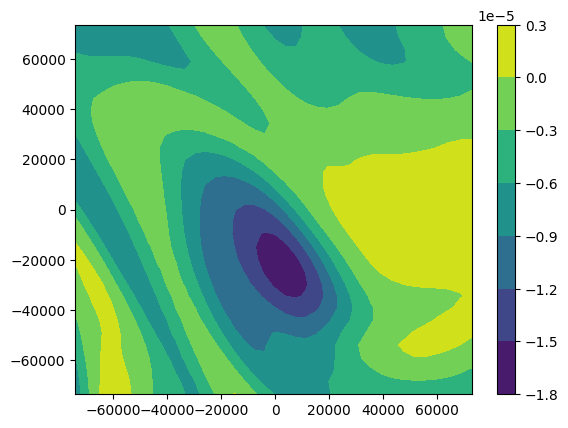

In [4]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]
SEARCH_WIDTH = 150000
DEPTH_LVL_LIMIT = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

X, Y = np.meshgrid(x, y)

vort_masked = vort[i_left:i_right, j_down:j_up, 20, t_mod]

ax = plt.contourf(X, Y, vort_masked.T)
plt.colorbar(ax)

In [2]:
def closed_convex_contour_checker(x, y, p, lvl):
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)
    pi = griddata((x, y), p, (xi, yi), method='cubic')
    contour_set = plt.contour(xi, yi, pi, levels=[lvl])
    paths = contour_set.allsegs[0]
    plt.close() 
    for path in paths:
        vertices = np.array(path)

    x = vertices[:, 0]
    y = vertices[:, 1]

    def is_closed_shape(x, y):
        return x[0] == x[-1] and y[0] == y[-1]

    def is_convex_shape(x, y):
        def cross_product(o, a, b):
            return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])
        
        n = len(x)
        if n < 4:  # A convex polygon must have at least 3 vertices, and the first and last should be the same
            return False
        
        sign = None
        for i in range(n - 2):
            p1, p2, p3 = (x[i], y[i]), (x[i+1], y[i+1]), (x[i+2], y[i+2])
            cross_prod = cross_product(p1, p2, p3)
            
            if cross_prod != 0:
                current_sign = np.sign(cross_prod)
                if sign is None:
                    sign = current_sign
                elif sign != current_sign:
                    return False
        return True

    if is_closed_shape(x, y) and is_convex_shape(x, y):
        return True
    else:
        return false


## Lagrangian

In [74]:
R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]
SEARCH_WIDTH = 400000
DEPTH_LVL_LIMIT = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

previous_file_idx = -1

WIDTH = len(range(i_left, i_right))
LENGTH = len(range(j_down, j_up))
TIMES = 20

u_data = np.full((WIDTH, LENGTH, TIMES), np.nan)
v_data = np.full((WIDTH, LENGTH, TIMES), np.nan)

for day in range(20):

    edata = eddies['Eddy15'].iloc[day]
    t = extract_number(edata.name)
    
    t_mod = t % 30
    file_idx = np.floor(t/30)
    if file_idx != previous_file_idx:
        fnumber = '0'+str(round(1461+ file_idx*30))
        uu = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
        vv = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
        previous_file_idx = file_idx

    u_data[:,:,day] = uu[i_left:i_right, j_down:j_up, 5, t_mod]
    v_data[:,:,day] = vv[i_left:i_right, j_down:j_up, 5, t_mod]

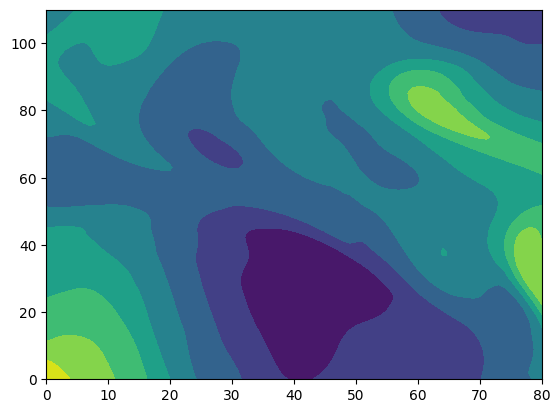

In [80]:
plt.contourf(u_data[:,:,19])